# Import libraries

In [1]:
from deap import tools, base
from deap.algorithms import eaMuPlusLambda
from deap import creator
from deap import benchmarks
from deap import algorithms

from multiprocessing import Pool

In [2]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
from numpy import random as rnd

import matplotlib.pyplot as plt


import sys
sys.path.append(r'C:\Users\1\Desktop\GitHub\Fedot.Industrial') #SST
from core.operation.transformation.WindowSelection import WindowSizeSelection
from core.models.detection.subspaces.SSTdetector import SingularSpectrumTransformation

from tsad.evaluating.evaluating import evaluating #F1 score

from detecta import detect_cusum #CUMSUM

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data loading

In [3]:
def df_expirement():
    url = "https://storage.yandexcloud.net/cloud-files-public/dataframe.csv"
    df = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep='|')
    return df

In [4]:
df = df_expirement()
df_columns = df.columns
first_label_list = df[df_columns[0]].unique()
df_aa564g = df[df[df_columns[0]] == first_label_list[0]]
df_aa564g_first = df_aa564g.drop(axis=1, labels=(df_aa564g.columns[0])) \
    .drop(axis=1, labels=(df_aa564g.columns[1]))[['uR/h', 'unitless']].reset_index(drop=True)
df_edited_ = df_aa564g_first.loc[df_aa564g_first['unitless'] >= 0]\
.loc[df_aa564g_first['uR/h'] >= 0].reset_index(drop=True)
df = df_edited_

cp_1 = []
for i in range(len(df)-1):
    if df['unitless'][i] !=  df['unitless'][i+1]:
        cp_1.append(1)
    else:
        cp_1.append(0)
df['change_points'] = cp_1 + [0]

ts = list(df['uR/h'])

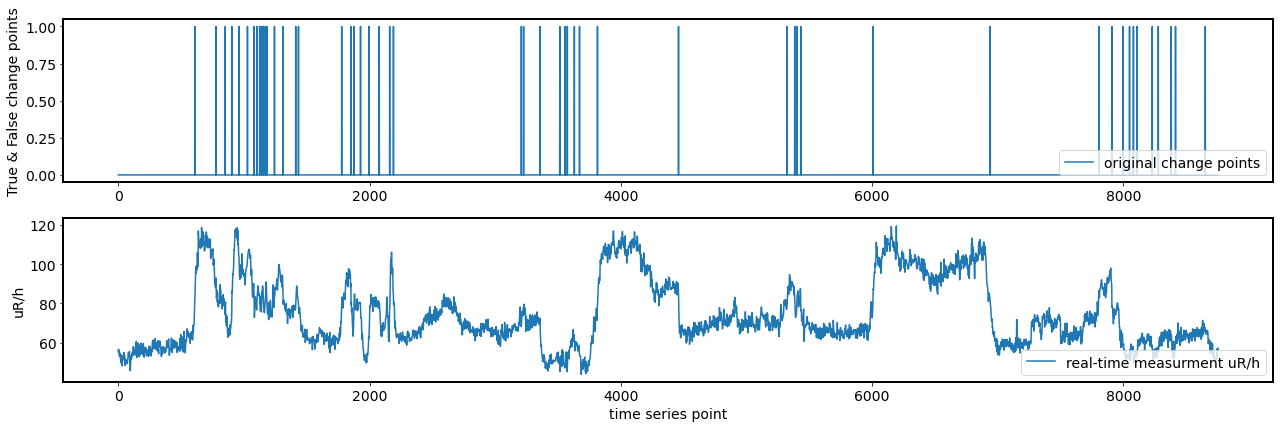

In [5]:
figure, axis = plt.subplots(2, 1, figsize=(18,6))
  
axis[0].plot(df.change_points, label='original change points')
#axis[0].set_title("Sine Function")
axis[0].legend(loc='lower right')
axis[0].set_ylabel('True & False change points')


axis[1].plot(df['uR/h'], label='real-time measurment uR/h')
#axis[1].set_title("Cosine Function")
axis[1].legend(loc='lower right')
axis[1].set_ylabel('uR/h')
#axis[1].set_xlabel('uR/h')

plt.xlabel("time series point")
plt.tight_layout()
plt.show()

# Model config

#### F1 score function

In [6]:
def cumsum_editor(score):
    ending, start, alarm, cumsum = detect_cusum(score, np.mean(score)+3*np.std(score), np.std(score), True, False)
    new_score = []
    for i in range(len(score)):
        if i in alarm:
            new_score.append(1)
        else:
            new_score.append(0)
    return new_score

In [7]:
def f1_evaluation(df):
    averate_time, missed_cp, FPs, true_anomalies = evaluating(df['true_cp'], df['predicted_cp'], metric='average_time', numenta_time='30 sec')
    TP = true_anomalies - missed_cp
    precision = TP/(TP+FPs)
    recall = TP/(TP+missed_cp)
    F1 =  2*precision*recall/(precision+recall)
    return F1

In [8]:
def temp_df_creator(score):
    t_0 = np.arange(len(score)).astype('datetime64[s]')
    df_0 = pd.DataFrame(index=t_0, columns=['predicted_cp'])
    df_0['predicted_cp'] = np.array(score)
    df_0['true_cp'] = np.array(df.change_points)[:len(score)]
    return df_0

In [9]:
def function(individual):
    if individual[2] > individual[0]:
        F1 = 0
    else:
        scorer = SingularSpectrumTransformation(time_series = np.array(ts),
                                                ts_window_length = individual[0],
                                                lag = individual[1],
                                                trajectory_window_length = individual[2])
        score = cumsum_editor(scorer.score_offline(dynamic_mode=True))
        df = temp_df_creator(score)
        F1 = f1_evaluation(df)
    return F1,

#### eaMuCommaLambda setup

In [10]:
creator.create("BaseFitness", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.BaseFitness)

toolbox = base.Toolbox()
toolbox.register("map", map)

toolbox.register("attribute", rnd.randint, 10, 300)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=3)

toolbox.register("population", tools.initRepeat, list, toolbox.individual, 30)


toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, 10, 300, 0.7)

toolbox.register("select", tools.selTournament, tournsize=4)
toolbox.register("evaluate", function)


hof = tools.HallOfFame(3, np.array_equal)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [11]:
pop = toolbox.population()
print(np.array(pop))

[[195  56 184]
 [160 109 253]
 [203  44 167]
 [126 161 111]
 [287 125  70]
 [ 82  35  27]
 [ 46  92 227]
 [271 166 284]
 [ 90 245 129]
 [282 194 108]
 [195 299 184]
 [236 210  78]
 [ 28  75  84]
 [ 32 162 191]
 [273  97  47]
 [289 296 248]
 [102  36 266]
 [251 199 261]
 [251 299 195]
 [251  35 136]
 [217 114 206]
 [168  72  24]
 [157 185 152]
 [265 238 258]
 [138  56  94]
 [243  33  34]
 [176 109 248]
 [146 265  12]
 [245 101 282]
 [114 267 236]]


# Model run

In [12]:
# if __name__ == "__main__":
#     pool = Pool()
#     toolbox.register("map", pool.map)

In [ ]:
pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, mu=len(pop), lambda_=len(pop), cxpb=0.5, mutpb=0.2, ngen=30,
                                   stats=stats, halloffame=hof, verbose=True)

Intersection of scoring windows(Timestamp('1970-01-01 00:17:59'), Timestamp('1970-01-01 00:17:53'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:23'), Timestamp('1970-01-01 00:18:15'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:45'), Timestamp('1970-01-01 00:18:30'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:00'), Timestamp('1970-01-01 00:18:44'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:14'), Timestamp('1970-01-01 00:19:00'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:30'), Timestamp('1970-01-01 00:19:12'))
Intersection of scoring windows(Timestamp('1970-01-01 00:23:32'), Timestamp('1970-01-01 00:23:24'))
Intersection of scoring windows(Timestamp('1970-01-01 00:30:51'), Timestamp('1970-01-01 00:30:46'))
Intersection of scoring windows(Timestamp('1970-01-01 00:36:00'), Timestamp('1970-01-01 00:36:00'))
Intersection of scoring windows(Timestamp('1970-01-01 00:53:28'), Timestamp('1970-01-01 00:53:16'))


In [ ]:
logbook_gen = [logbook[i]['gen'] for i in range(len(logbook))]
logbook_avg = [logbook[i]['avg'] for i in range(len(logbook))]
logbook_std = [logbook[i]['std'] for i in range(len(logbook))]
logbook_min = [logbook[i]['min'] for i in range(len(logbook))]
logbook_max = [logbook[i]['max'] for i in range(len(logbook))]

plt.figure(figsize=(18, 6))
plt.plot(logbook_gen, logbook_min, label = 'min_f1', color='red')
plt.plot(logbook_gen, logbook_max, label = 'max_f1', color='blue')
plt.plot(logbook_gen, logbook_std, label = 'std_f1', color='green', linewidth=2)
plt.plot(logbook_gen, logbook_avg, label = 'average_f1', color='black')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('F1 score')
plt.title('Alg. eaMuPlusLambda | popsize = 21 | CUMSUM filter')
plt.plot()

print("Best = {}".format(hof[0]))
print("Best fit = {}".format(hof[0].fitness.values[0]))